In [60]:
import numpy as np
from scipy.optimize import fsolve
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [61]:
# Setup

class Economy:
    cl = 0
    ch = 1
    vl = 0
    vh = 1
    
    def __init__(self,G,F,g,f):
        self.G = G
        self.g = g
        self.F = F
        self.f = f
    
    def B_virtual(self,x):
        if x>=self.vh-1e-5:
            y = self.vh-1e-5
        elif x<=self.vl+1e-5:
            y=self.vl+1e-5
        else:
            y=x
        return y-(1-self.F(y))/self.f(y)
    
    def S_virtual(self,x):
        if x>=self.ch-1e-5:
            y = self.ch-1e-5
        elif x<=self.cl+1e-5:
            y=self.cl+1e-5
        else:
            y=x
        return y+ self.G(y)/self.g(y)
    
    def royalty_p(self,x):
        integral = integrate.quad(lambda y: self.G(self.B_virtual(y)), 0, x)[0]
        return x - integral/(self.G(self.B_virtual(x)))
    
    def no_royalty_p(self,x):
        return fsolve(lambda y: self.S_virtual(y)-x, 0.2)
    
    def BS_surp_royalty(self):
        prob_trade = lambda y: self.G(self.B_virtual(y))
        return integrate.quad(lambda y: prob_trade(y)*(y-self.royalty_p(y))*self.f(y),self.vl,self.vh)[0]
    
    def BS_surp_no_royalty(self):
        prob_trade = lambda y: self.G(self.B_virtual(y))
        return integrate.quad(lambda y: prob_trade(y)*(y-self.no_royalty_p(y))*self.f(y),self.vl,self.vh)[0]
    
    def welfare_royalty(self):
        low_v =  fsolve(lambda y: self.B_virtual(y)-max(self.cl,self.B_virtual(self.vl)), 0.2)
        return integrate.dblquad(lambda y,x: (x-y)*self.f(x)*self.g(y),low_v,self.vh,self.cl,self.B_virtual)[0]
    
    def welfare_no_royalty(self):
        return integrate.dblquad(lambda y,x: (x-y)*self.f(x)*self.g(y),self.vl,self.vh,self.cl,self.no_royalty_p)[0]
    
        

In [72]:
# Define distributions

def G(x,lam=2,cl=0,ch=1):
        if x>= ch-1e-5:
            y = ch-1e-2
        elif x<= cl+1e-5:
            y= cl+1e-5
        else:
            y=x
        return (1-np.exp(-lam*y))/(1-np.exp(-lam))
    
def g(x,lam=2,cl=0,ch=1):
    if x>= ch-1e-5:
        y = ch-1e-5
    elif x<= cl+1e-5:
        y= cl+1e-5
    else:
        y=x
    return (lam*np.exp(-lam*y))/(1-np.exp(-lam))
    
def F(x,vn,vl=0,vh=1):
    if x>= vh-1e-5:
        y = vh-1e-5
    elif x<=vl+1e-5:
        y=vl+1e-5
    else:
        y=x
    return (y**vn-vl**vn)/(vh**vn-vl**vn)

def f(x,vn,vl=0,vh=1):
    if x>= vh-1e-5:
        y = vh-1e-5
    elif x<=vl+1e-5:
        y=vl+1e-5
    else:
        y=x
    return vn*(y**(vn-1))/(vh**vn-vl**vn)

In [73]:
ns = np.linspace(1,3,100)

welfares = {x : None for x in ns}

good_royalties = []
welfares_royalty = []
welfares_no_royalties = []
Royalties_Good = False
for n in ns:
    Fn = lambda x: F(x,n)
    fn = lambda x: f(x,n)
    Econ = Economy(G,Fn,g,fn)
    n1 = Econ.BS_surp_royalty()
    n2 = Econ.BS_surp_no_royalty()        
    n3 = Econ.welfare_royalty()
    n4 = Econ.welfare_no_royalty()
    welfares_royalty.append(n3)
    welfares_no_royalties.append(n4)
    welfares[n] = (n3,n4)

<ipython-input-61-78bf71b74ed6>:42: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda y: prob_trade(y)*(y-self.royalty_p(y))*self.f(y),self.vl,self.vh)[0]


In [74]:
grid_size = len(ns)
welfare_royalties_grid = np.empty([grid_size])
welfare_no_royalties_grid = np.empty([grid_size])
for i, n in enumerate(ns):
    welfare_royalties_grid[i] = welfares[n][0]
    welfare_no_royalties_grid[i] = welfares[n][1]

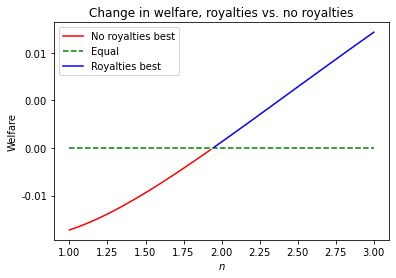

In [75]:
pos_vals = []
neg_vals = []
for x in welfare_royalties_grid-welfare_no_royalties_grid:
    if x>=0:
        pos_vals.append(x)
        neg_vals.append(None)
    if x<=0:
        neg_vals.append(x)
        pos_vals.append(None)
plt.plot(np.linspace(1,3,100),neg_vals, color='r',label='No royalties best')
plt.plot(np.linspace(1,3,100),[0 for x in range(0,100)], color='g',linestyle='--',label='Equal')
plt.plot(np.linspace(1,3,100),pos_vals, color='b', label='Royalties best')
plt.xlabel(r"$n$") 
plt.ylabel(r"Welfare")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.legend()
plt.title(r"Change in welfare, royalties vs. no royalties")
plt.savefig('C:/Countervailing Paper/welfare_change_pos_neg', 
            bbox_inches='tight')